2. Построение моделей для прогноза модуля упругости при растяжении и прочности при растяжении

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle

In [2]:
#Cмонтируем весь Google Disk в Colab:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Загружаем объединенный, очищенный и нормализорванный датасет
df_norm = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/ВКР/data/X_sum_norm.xlsx')
#Удаляем лишний столбец
df_norm = df_norm.drop(columns='Unnamed: 0')
df_norm.describe()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,Угол нашивки
count,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000,922.000000
mean,0.499412,0.502904,0.451341,0.506200,0.490578,0.516739,0.373295,0.487343,0.503776,0.507876,0.503426,0.503938,0.510846
std,0.187858,0.188395,0.201534,0.186876,0.180548,0.190721,0.217269,0.196366,0.188668,0.199418,0.183587,0.193933,0.500154
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.371909,0.368184,0.305188,0.378514,0.366571,0.386228,0.204335,0.353512,0.373447,0.374647,0.372844,0.376869,0.000000
50%,0.495189,0.511396,0.451377,0.506382,0.488852,0.516931,0.354161,0.483718,0.501481,0.510143,0.506414,0.504310,1.000000
75%,0.629774,0.624719,0.587193,0.638735,0.623046,0.646553,0.538397,0.617568,0.624299,0.642511,0.626112,0.630842,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
#Загружаем объединенный датасет
df = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/ВКР/data/X_sum.xlsx')
#Удаляем лишний столбец
df = df.drop(columns='Unnamed: 0')

In [6]:
#Разбиваем данные на обучающую и тестовую выборки
X_1 = df_norm.drop(['Модуль упругости при растяжении, ГПа'], axis=1)
X_2 = df_norm.drop(['Прочность при растяжении, МПа'], axis=1)
y_1 = df_norm[['Модуль упругости при растяжении, ГПа']]
y_2 = df_norm[['Прочность при растяжении, МПа']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=1)

print ('Тренировочная часть для Модуля упругости при растяжении: %d строк\nТестовая часть для Модуля упругости при растяжении:    : %d строк' % (X_train_1.shape[0], X_test_1.shape[0]))
print ('Тренировочная часть для Прочности при растяжении: %d строк\nТестовая часть для Прочности при растяжении    : %d строк' % (X_train_2.shape[0], X_test_2.shape[0]))

Тренировочная часть для Модуля упругости при растяжении: 645 строк
Тестовая часть для Модуля упругости при растяжении:    : 277 строк
Тренировочная часть для Прочности при растяжении: 645 строк
Тестовая часть для Прочности при растяжении    : 277 строк


In [7]:
#Инвертирование значений из нормализованных
#Создаем ненормализованные значения 'Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа'
y_nonnorm_1 = df[['Модуль упругости при растяжении, ГПа']]
y_nonnorm_2 = df[['Прочность при растяжении, МПа']]
min_max_scaler_1 = MinMaxScaler()
min_max_scaler_2 = MinMaxScaler()
#Нормализуем значения с помощью MinMaxScaler
df_y_1 = pd.DataFrame(min_max_scaler_1.fit_transform(y_nonnorm_1))
df_y_2 = pd.DataFrame(min_max_scaler_2.fit_transform(y_nonnorm_2))
#Инвертируем нормализованное предсказанное значение
#y_predict_nonnorm1 = min_max_scaler_1.inverse_transform(y_predict_1)


Метод К ближайших соседей

In [ ]:
#Для Модуля упругости при растяжении
# Обучение модели на тренировочных данных
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_1, y_train_1)

# Прогнозирование значений на тестовых данных
y_pred_1 = knn.predict(X_test_1)

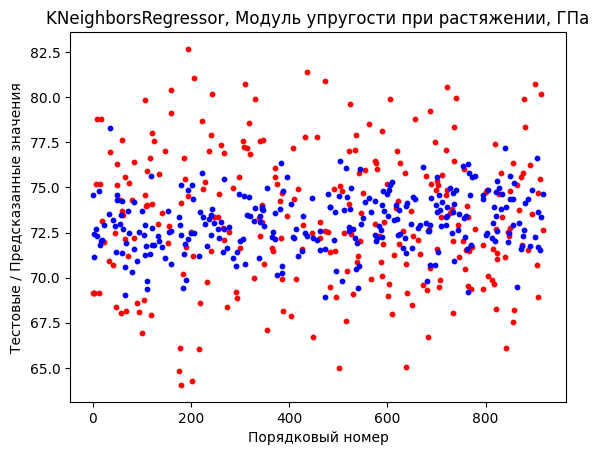

In [ ]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_test_1), c = 'r', s = 10)
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_pred_1), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('KNeighborsRegressor, Модуль упругости при растяжении, ГПа')
plt.show()

In [ ]:
#Запишем получившиеся данные по оценке качества модели метода K ближайших соседей для Модуля упругости при растяжении
models = pd.DataFrame()
knr_upr_result = pd.DataFrame({
   'Model': 'KNeighborsRegressor_upr', 
   'MSE': mean_squared_error(y_test_1, y_pred_1),
   'MAE': mean_absolute_error(y_test_1, y_pred_1), 
   'R2 score': r2_score(y_test_1, y_pred_1).round(3)
}, index=['Модуль упругости при растяжении'])
models = pd.concat([models, knr_upr_result])
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295


In [ ]:
#Сохраним модель
with open('/content/gdrive/MyDrive/Colab Notebooks/ВКР/knn_pkl.pkl', 'wb') as f:
  pickle.dump(knn, f)

In [ ]:
#Загрузим модель
with open('/content/gdrive/MyDrive/Colab Notebooks/ВКР/knn_pkl.pkl', 'rb') as f:
  load_model = pickle.load(f)

In [ ]:
X_frame_1 = X_test_1[0:1]
X_frame_1

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2",Шаг нашивки,Плотность нашивки,Угол нашивки
827,0.275971,0.554733,0.06155,0.72736,0.637922,0.849159,0.019718,0.353659,0.485873,0.490829,0.561927,1


In [ ]:
y_predict_1 = load_model.predict(X_frame_1)
y_predict_1

array([[0.58466172]])

array([[74.94513348]])

In [ ]:
#Для прочности при растяжении
# Обучение модели на тренировочных данных 

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_2, y_train_2)

# Прогнозирование значений на тестовых данных
y_pred_2 = knn.predict(X_test_2)

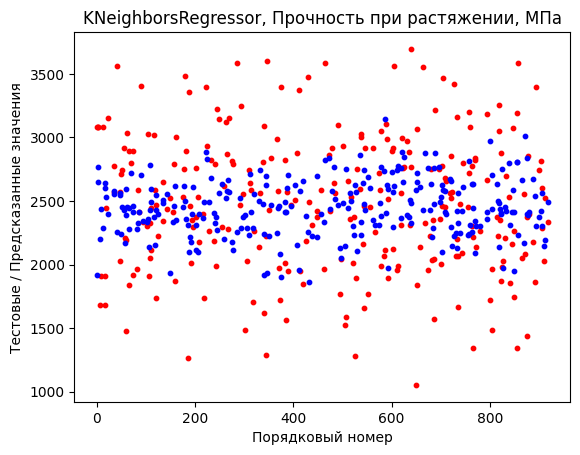

In [ ]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_test_2), c = 'r', s = 10)
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_pred_2), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('KNeighborsRegressor, Прочность при растяжении, МПа')
plt.show()

In [ ]:
#Запишем получившиеся данные по оценке качества модели метода K ближайших соседей для прочности при растяжении
knr_pr_result = pd.DataFrame({
   'Model': 'KNeighborsRegressor_pr', 
   'MSE': mean_squared_error(y_test_2, y_pred_2),
   'MAE': mean_absolute_error(y_test_2, y_pred_2), 
   'R2 score': r2_score(y_test_2, y_pred_2).round(3)
}, index=['Прочность при растяжении'])
models = pd.concat([models, knr_pr_result])

In [ ]:
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266


Стохастический градиентный спуск

In [ ]:
##Для Модуля упругости при растяжении
# Создание модели
sgd_1 = SGDRegressor()

# Создание сетки параметров для перебора
param_grid = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate' : ['optimal', 'invscaling', 'adaptive'],
    'tol': [0.001, 0.0001, 0.00001]
}

# Создание объекта GridSearchCV
grid = GridSearchCV(sgd_1, param_grid, cv=5, n_jobs=-1)

# Обучение модели на тренировочных данных
grid.fit(X_train_1, y_train_1.values.ravel())

# Вывод наилучших параметров и оценки качества модели

sgd_1 = grid.best_estimator_
y_pred_1 = sgd_1.predict(X_test_1)
#Преобразование Numpy в DataFrame
y_pred_1 = pd.DataFrame(data=y_pred_1)


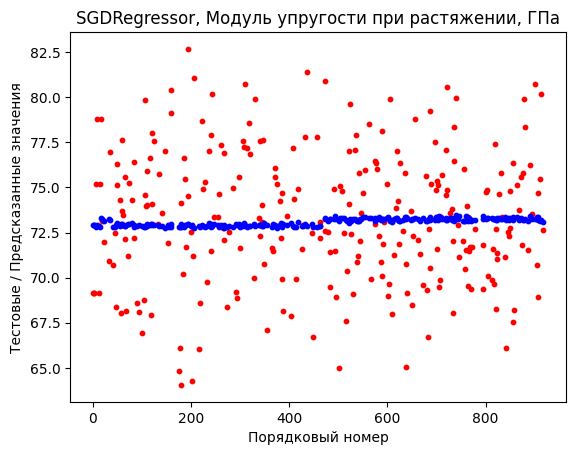

In [ ]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_test_1), c = 'r', s = 10)
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_pred_1), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('SGDRegressor, Модуль упругости при растяжении, ГПа')
plt.show()

In [ ]:
#Запишем данные по оценке качества модели метода Стохастический градиентный спуск для модуля упругости при растяжении
sgd_1_result = pd.DataFrame({
   'Model': 'SGDRegressor_upr', 
   'MSE': mean_squared_error(y_test_1, y_pred_1),
   'MAE': mean_absolute_error(y_test_1, y_pred_1),
   'R2 score': sgd_1.score(X_test_1, y_test_1).round(3)
}, index=['Модуль упругости при растяжении'])
models = pd.concat([models, sgd_1_result])

In [ ]:
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266
Модуль упругости при растяжении,SGDRegressor_upr,0.038705,0.159921,-0.011


In [ ]:
# Прочность при растяжении
# Создание модели
sgd_2 = SGDRegressor()

# Создание сетки параметров для перебора
param_grid = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate' : ['optimal', 'invscaling', 'adaptive'],
    'tol': [0.001, 0.0001, 0.00001]
}

# Создание объекта GridSearchCV
grid = GridSearchCV(sgd_2, param_grid, cv=5, n_jobs=-1)

# Обучение модели на тренировочных данных
grid.fit(X_train_2, y_train_2.values.ravel())

# Вывод наилучших параметров и оценки качества модели

sgd_2 = grid.best_estimator_
y_pred_2 = sgd_2.predict(X_test_2)
#Преобразование Numpy в DataFrame
y_pred_2 = pd.DataFrame(data=y_pred_2)

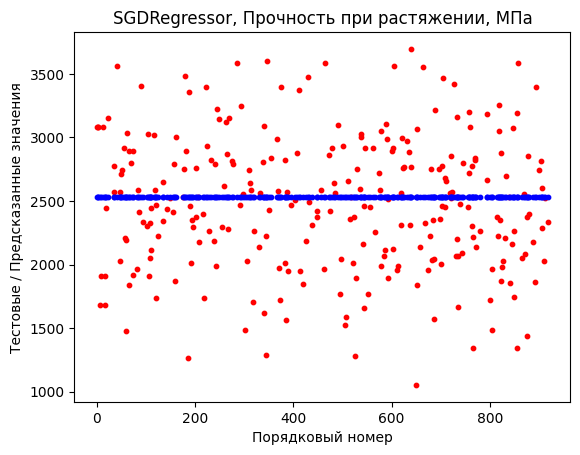

In [ ]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_test_2), c = 'r', s = 10)
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_pred_2), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('SGDRegressor, Прочность при растяжении, МПа')
plt.show()

In [ ]:
#Запишем данные по оценке качества модели метода Стохастический градиентный спуск для Прочности при растяжении
sgd_2_result = pd.DataFrame({
   'Model': 'SGDRegressor_pr', 
   'MSE': mean_squared_error(y_test_2, y_pred_2),
   'MAE': mean_absolute_error(y_test_2, y_pred_2),
   'R2 score': sgd_2.score(X_test_2, y_test_2).round(3)
}, index=['Прочность при растяжении'])
models = pd.concat([models, sgd_2_result])

In [ ]:
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266
Модуль упругости при растяжении,SGDRegressor_upr,0.038705,0.159921,-0.011
Прочность при растяжении,SGDRegressor_pr,0.035107,0.151721,-0.008


Линейная регрессия

In [8]:
#Линейная регрессия 1 - Модуль упругости при растяжении
# Обучаем модель линейной регресси на тренировочных данных
linear = LinearRegression().fit(X_train_1, y_train_1)

# Оцениваем модель, используя тестовые данные. Обученная модель запускается в X_test и извлекаются показатели.
y_pred_1 = linear.predict(X_test_1)

y_train_1_pred = linear.predict(X_train_1)

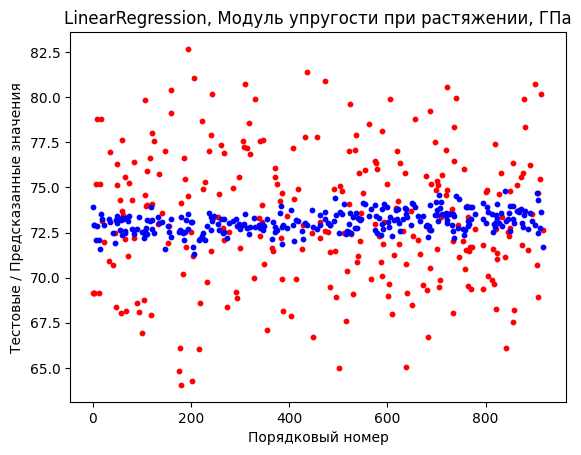

In [9]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_test_1), c = 'r', s = 10)
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_pred_1), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('LinearRegression, Модуль упругости при растяжении, ГПа')
plt.show()

In [ ]:
#Запишем данные по оценке качества модели метода Линейная регрессия  для Модуля упругости при растяжении
y_pred_1_result = pd.DataFrame({
   'Model': 'LinearRegression_upr', 
   'MSE': mean_squared_error(y_test_1, y_pred_1),
   'MAE': mean_absolute_error(y_test_1, y_pred_1),
   'R2 score': linear.score(X_test_1, y_test_1).round(3)
}, index=['Модуль упругости при растяжении'])
models = pd.concat([models, y_pred_1_result])

In [ ]:
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266
Модуль упругости при растяжении,SGDRegressor_upr,0.038705,0.159921,-0.011
Прочность при растяжении,SGDRegressor_pr,0.035107,0.151721,-0.008
Модуль упругости при растяжении,LinearRegression_upr,0.039564,0.161937,-0.034


In [10]:
#линейная регрессия 2 -	Прочность при растяжении, МПа
# Обучаем модель линейной регресси на тренировочных данных
linear = LinearRegression().fit(X_train_2, y_train_2)

# Оцениваем модель, используя тестовые данные. Обученная модель запускается в X_test и извлекаются показатели.
y_pred_2 = linear.predict(X_test_2)
y_train_2_pred = linear.predict(X_train_2)

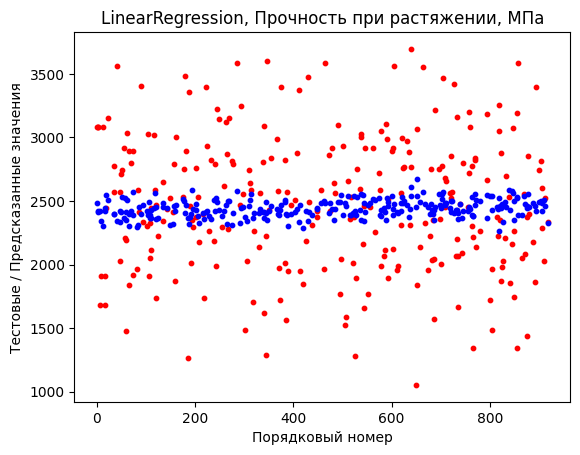

In [12]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_test_2), c = 'r', s = 10)
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_pred_2), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('LinearRegression, Прочность при растяжении, МПа')
plt.show()

In [ ]:
y_pred_2_result = pd.DataFrame({
   'Model': 'LinearRegression_pr', 
   'MSE': mean_squared_error(y_test_2, y_pred_2),
   'MAE': mean_absolute_error(y_test_2, y_pred_2),
   'R2 score': linear.score(X_test_2, y_test_2).round(3)
}, index=['Прочность при растяжении'])
models = pd.concat([models, y_pred_2_result])

In [ ]:
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266
Модуль упругости при растяжении,SGDRegressor_upr,0.038705,0.159921,-0.011
Прочность при растяжении,SGDRegressor_pr,0.035107,0.151721,-0.008
Модуль упругости при растяжении,LinearRegression_upr,0.039564,0.161937,-0.034
Прочность при растяжении,LinearRegression_pr,0.034523,0.149937,0.009


 Cлучайный лес (Random forest)

In [13]:
# Создание модели случайного леса для модуля упругости при растяжении
rf_1 = RandomForestRegressor()

# Создание сетки параметров для перебора
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание объекта GridSearchCV
grid = GridSearchCV(rf_1, param_grid, cv=5, n_jobs=-1)

# Обучение модели на тренировочных данных
grid.fit(X_train_1, y_train_1)

# Вывод наилучших параметров и оценки качества модели
rf_1_best = grid.best_estimator_
print(f'R2-score случайного леса: {rf_1_best.score(X_test_1, y_test_1).round(3)}')

y_pred_1 = rf_1_best.predict(X_test_1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


R2-score случайного леса: -0.072


In [15]:
#Преобразование Numpy в DataFrame
y_pred_1 = pd.DataFrame(data=y_pred_1)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


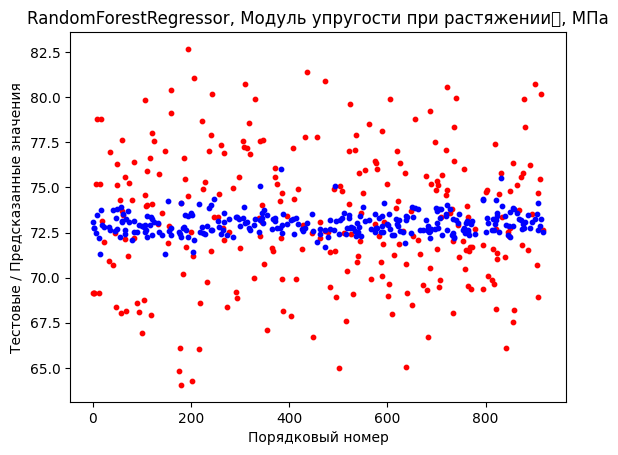

In [16]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_test_1), c = 'r', s = 10)
plt.scatter(y_test_1.index, min_max_scaler_1.inverse_transform(y_pred_1), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('RandomForestRegressor, Модуль упругости при растяжении	, МПа')
plt.show()

In [ ]:
rf_1_result = pd.DataFrame({
   'Model': 'RandomForestRegressor_upr', 
   'MSE': mean_squared_error(y_test_1, y_pred_1),
   'MAE': mean_absolute_error(y_test_1, y_pred_1),
   'R2 score': rf_1_best.score(X_test_1, y_test_1).round(3)
}, index=['Модуль упругости при растяжении'])
models = pd.concat([models, rf_1_result])

In [ ]:
models

,Model,MSE,MAE,R2 score
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266
Модуль упругости при растяжении,SGDRegressor_upr,0.038705,0.159921,-0.011
Прочность при растяжении,SGDRegressor_pr,0.035107,0.151721,-0.008
Модуль упругости при растяжении,LinearRegression_upr,0.039564,0.161937,-0.034
Прочность при растяжении,LinearRegression_pr,0.034523,0.149937,0.009
Модуль упругости при растяжении,RandomForestRegressor_upr,0.040606,0.164424,-0.061


In [17]:
# Создание модели случайного леса для Прочности при растяжении
rf_2 = RandomForestRegressor()

# Создание сетки параметров для перебора
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание объекта GridSearchCV
grid = GridSearchCV(rf_1, param_grid, cv=5, n_jobs=-1)

# Обучение модели на тренировочных данных
grid.fit(X_train_2, y_train_2)

# Вывод наилучших параметров и оценки качества модели
rf_2_best = grid.best_estimator_
print(f'R2-score случайного леса: {rf_2_best.score(X_test_2, y_test_2).round(3)}')

y_pred_2 = rf_2_best.predict(X_test_2)
#Преобразование Numpy в DataFrame
y_pred_2 = pd.DataFrame(data=y_pred_2)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


R2-score случайного леса: -0.013


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


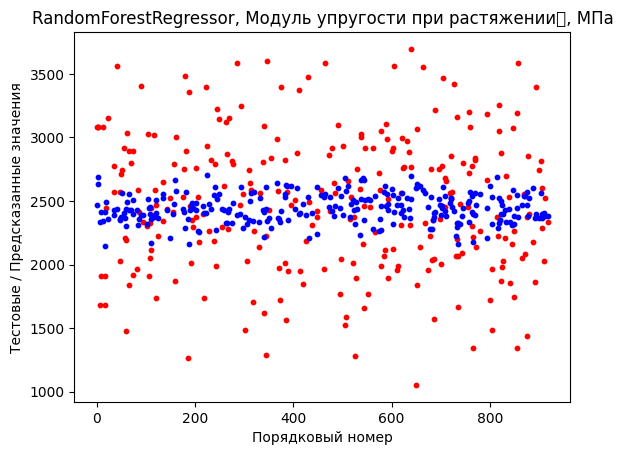

In [18]:
# Визуализация разброса предсказанных данных и тестовых данных
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_test_2), c = 'r', s = 10)
plt.scatter(y_test_2.index, min_max_scaler_2.inverse_transform(y_pred_2), c = 'b', s = 10)
plt.xlabel('Порядковый номер')
plt.ylabel('Тестовые / Предсказанные значения')
plt.title('RandomForestRegressor, Модуль упругости при растяжении	, МПа')
plt.show()

In [ ]:
rf_2_result = pd.DataFrame({
   'Model': 'RandomForestRegressor_pr', 
   'MSE': mean_squared_error(y_test_2, y_pred_2),
   'MAE': mean_absolute_error(y_test_2, y_pred_2),
   'R2 score': rf_2_best.score(X_test_2, y_test_2).round(3)
}, index=['Прочность при растяжении'])
models = pd.concat([models, rf_2_result])

In [ ]:
#Выведем получившиеся данные
models_sort = models.sort_values(by=['MAE', 'R2 score'])
models_sort

,Model,MSE,MAE,R2 score
Прочность при растяжении,LinearRegression_pr,0.034523,0.149937,0.009
Прочность при растяжении,RandomForestRegressor_pr,0.035424,0.151399,-0.017
Прочность при растяжении,SGDRegressor_pr,0.035107,0.151721,-0.008
Модуль упругости при растяжении,SGDRegressor_upr,0.038705,0.159921,-0.011
Модуль упругости при растяжении,LinearRegression_upr,0.039564,0.161937,-0.034
Модуль упругости при растяжении,RandomForestRegressor_upr,0.040606,0.164424,-0.061
Прочность при растяжении,KNeighborsRegressor_pr,0.044102,0.165831,-0.266
Модуль упругости при растяжении,KNeighborsRegressor_upr,0.049561,0.181919,-0.295
